# Wykrywanie anomalii sieciowy &nbsp; | &nbsp; *Network Anomaly Detection*

## LAB 05 Ruch z AGH &nbsp; | &nbsp; *Traffic with AGH*

- Szeregi czasowe &nbsp; | &nbsp; *Time series*
- Periodyczność &nbsp; | &nbsp; Periodicity
- Zależność w czasie &nbsp; | &nbsp; Time dependency


## Plan
|  | | |
| -------- | -------|---- |
| Wprowadzenie | *Introduction* | 15 min |
| Fourier | *Fourier* |30 min |
| AR | *AR*  | 35 min |
| Podsumowanie | *Summary* | 10 min|

In [ ]:
#@title Required libraries
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set() # set default styles for seaborn
import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import adam
from jax.example_libraries import stax

In [ ]:
#@title download data file
!gdown https://drive.google.com/uc?id=1xJ7TJmKA3ft7IVnOF9YrsT8bM76sO-rv



Downloading...
From: https://drive.google.com/uc?id=1xJ7TJmKA3ft7IVnOF9YrsT8bM76sO-rv
To: /content/ucirtr-cyfronet.log
100% 118k/118k [00:00<00:00, 66.5MB/s]


In [ ]:
#@title Dane: read and add meaningful names for columns
# for example  columns A B C D E --> 'timestamp','incoming','outgoing','max_incoming','max_outgoing'
counters = pd.read_csv(
    'ucirtr-cyfronet.log', skiprows=1, sep=' ',
    names=['timestamp','incoming','outgoing','max_incoming','max_outgoing'])
counters.timestamp = pd.to_datetime(counters.timestamp,unit='s')
counters.set_index('timestamp',inplace=True)
counters = counters.sort_values(by='timestamp')
display(counters.head())


,incoming,outgoing,max_incoming,max_outgoing
timestamp,,,,
2017-09-13,40292444,15357511,162988733,40832989
2017-09-14,38873001,17792879,157782909,44368202
2017-09-15,28299196,16308216,92813412,40654395
2017-09-16,26632779,18698728,111451077,49603291
2017-09-17,10170789,30445926,40623316,56744526


In [ ]:
tdiff = np.diff(counters.index)
t2h = pd.to_timedelta(2,unit='h')
idx = (tdiff == t2h)
idx, = np.where(idx)
print(len(idx), idx[:20])

600 [732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749
 750 751]


(600, 2)


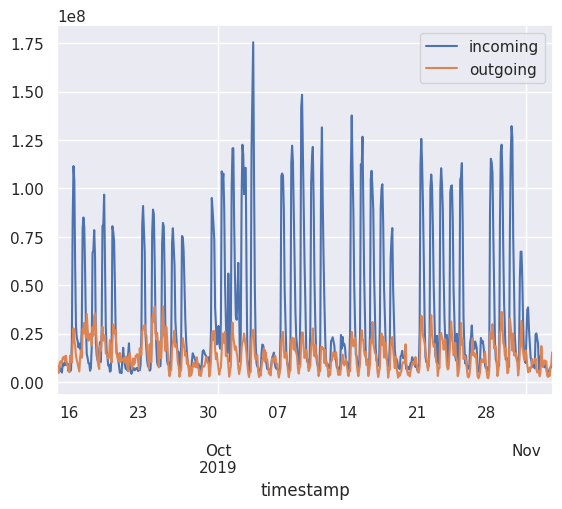

In [ ]:
df = counters.iloc[idx,[0,1]]
print(df.shape)
df.plot();

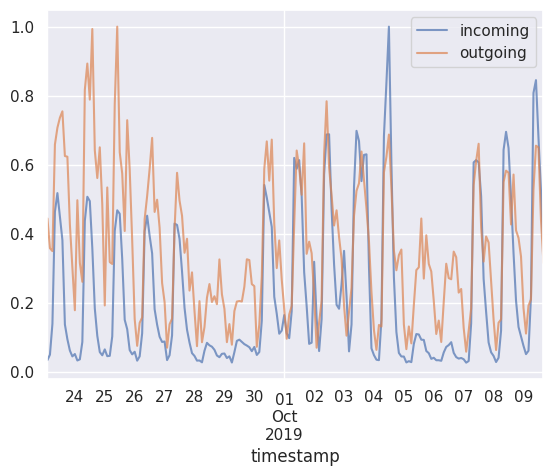

In [ ]:
df2 = df/df.max(axis=0).values
df2.iloc[100:300,:].plot(alpha=0.7);

# μ lib  &nbsp; | &nbsp; *micro library*




In [ ]:
def vector_mse(y,yhat):
    return jnp.mean(jnp.square(y-yhat), axis=-1)

def sin(t,omega):
    return jnp.sin(omega*t)

def cos(t,omega):
    return jnp.cos(omega*t)

omega_d = 2*np.pi/24
omega_w =  2*np.pi/(24*7)

def Fourier(n=2):
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (4*n*input_shape[-1],)
        return (output_shape, ())

    def apply_fun(params, inputs, **kwargs):
        harmonics = [sin(inputs,np.float32(i+1)*omega_w) for i in range(n)]+\
                    [cos(inputs,np.float32(i+1)*omega_w) for i in range(n)] +\
                    [sin(inputs,np.float32(i+1)*omega_d) for i in range(n)]+\
                    [cos(inputs,np.float32(i+1)*omega_d) for i in range(n)]
        return jnp.concatenate(harmonics, axis=-1)

    return init_fun, apply_fun

# Periodyczność (sezonowość)  &nbsp; | &nbsp; *Periodicity (seasonality)*



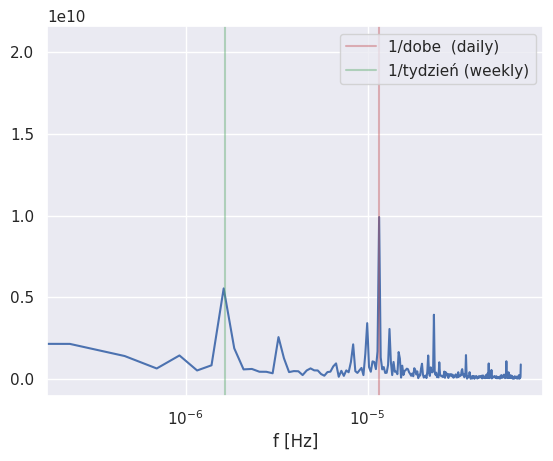

In [ ]:
a = df.incoming.to_numpy()
spectrum=np.fft.rfft(a)
n = a.size
timestep = 2*60*60

freq = np.fft.rfftfreq(n, d=timestep)

plt.plot(freq,(np.abs(spectrum)))
plt.xscale('log')
plt.axvline(x=1/(24*60*60),label='1/dobe  (daily)',color='r', alpha=0.4)
plt.axvline(x=1/(7*24*60*60),label='1/tydzień (weekly)',color='g', alpha=0.4)
plt.xlabel('f [Hz]')
plt.legend()

## Zadanie 1 | &nbsp; *Task 1*
Przedstawić ruch jako funkcję czasu. Wykorzystać funkcje $\sin$ i $\cos$.

*Present traffic as a function of time. Use the $\sin$ and $\cos$ functions.*



In [ ]:
t = pd.Series(df.index)
t = (t-t[0])/pd.to_timedelta(1,unit='h')
t = t.to_numpy()
y=df.to_numpy()

train_split=int(0.7*y.shape[0])

m = np.mean(y[:train_split,:],0)
s = np.std(y[:train_split,:],0)

y = (y-m)/s  # y~N(0,1)

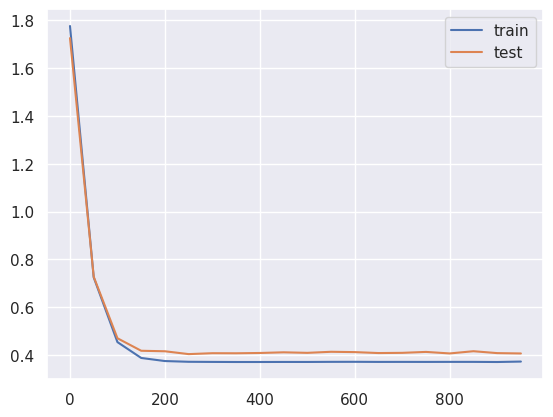

In [ ]:
#TODO

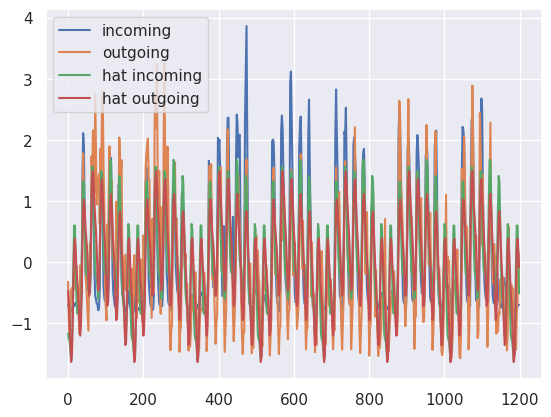

In [ ]:
plt.plot(t,y)
yhat = apply(get_params(opt_state),t[:,np.newaxis])
plt.plot(t,yhat)
plt.legend(['incoming','outgoing','hat incoming','hat outgoing'])

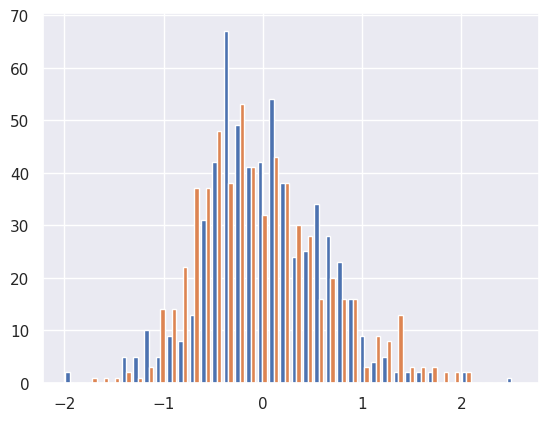

In [ ]:
err = (y-yhat)
plt.hist(err.T,40);

# Autokorelacja  &nbsp; | &nbsp; *Autocorrelation*

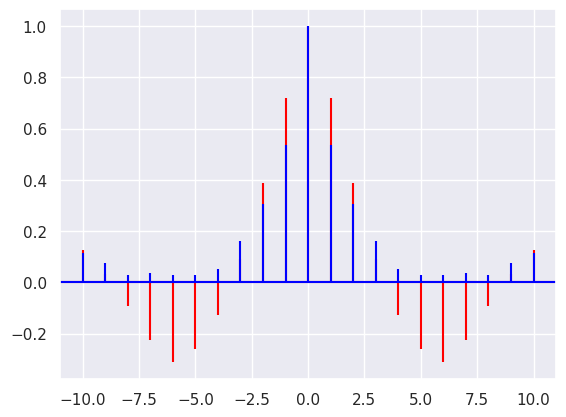

In [ ]:
plt.acorr(err[:,0],color='red');
plt.acorr(err[:,1], color='blue');

## Zadanie 2  &nbsp; | &nbsp; *Task 2*
Zbudowac model liniowy na błędach z dopasowanie funkcji trygonometrycznych.
Cel to przewidywanie błędu na podstawie trzech poprzednich błędów.

*Build a linear model on errors by fitting trigonometric functions.
The goal is to predict the error based on the three previous errors.*



In [ ]:
#TODO

seq:(597, 2, 4) x:(597, 2, 3), y:(597, 2, 1)
x:(597, 6), y:(597, 2)


<ipython-input-54-6eb97bf9a9af>:9: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  xe,ye = jax.tree_map(jax.vmap(jnp.ravel),(xe,ye))


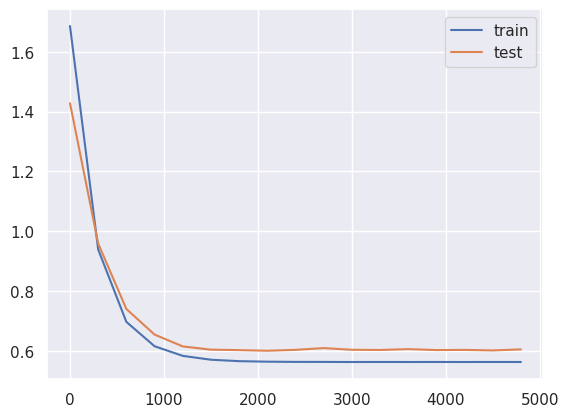

In [ ]:
#TODO

losses=[]
test_losses=[]
train_steps=[]

for i in range(steps):
    idx = np.random.randint(0,train_split,size=batch_size)
    bx = xe[idx,...]
    by = ye[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,by)

    if i % 300 == 0:
        bx = xe[train_split:,...]
        by = ye[train_split:,...]
        test_losses.append(test_loss(opt_state,bx,by))
        train_steps.append(i)
        losses.append(test_loss(opt_state,xe[:train_split,...],ye[:train_split,...]))

plt.plot(train_steps,losses,label='train')
plt.plot(train_steps,test_losses,label='test')

plt.legend()

## Zadanie 3  &nbsp;| &nbsp; *Task 3*
Wykryć anomalie na podstawie błędów z modelu.

*Detect anomalies based on errors from the model*




In [ ]:
#TODO

In [ ]:
#TODO

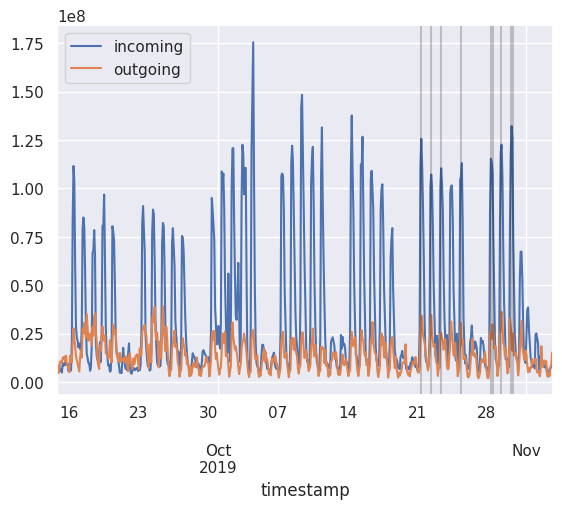

In [ ]:
#TODO